In [20]:
# TODO
#
# [ ] Use cached .png images instead of downloading from the web and converting to png

from IPython.display import SVG, display, Image
from cairo import Context, SVGSurface, ImageSurface, Surface, Error, FONT_SLANT_NORMAL, FONT_WEIGHT_NORMAL, FORMAT_ARGB32 

DISP_WIDTH = 512
DISP_HEIGHT = 256

# Display image in jupyter
def show_img(file):
    display(Image(filename=file))
    
def show_svg(file):
    display(SVG(filename=file))

# Decorator to display any cairo drawing. Saves result at tmp/example.svg and then shows.
def disp(*args, width = DISP_WIDTH, height = DISP_HEIGHT, **kwargs):
    def decorator_func(draw_func):
        with SVGSurface("tmp/tmp.svg", width, height) as surface:
            ctx = Context(surface)
            
            # border
            ctx.set_source_rgba(0, 0, 0, 1)
            ctx.rectangle(0, 0, width, height)
            ctx.set_line_width(2 * 0.002 * width)
            ctx.stroke()
            ctx.scale(width, height)
            
            draw_func(ctx, *args, **kwargs)
        show_svg("tmp/tmp.svg")
    return decorator_func

In [104]:
from game import *
from utils import *
from telegram import User
from urllib.request import urlopen
from PIL import Image
import math

#@disp(width=236, height=354, card=Card(image_id=16, _id=1))
def draw_card(ctx, card):
    file_jpeg = urlopen(card.url)
    pil_file_jpeg = Image.open(file_jpeg)
    png_filename = f'tmp/card_{card.image_id:0>5}.png'
    pil_file_jpeg.save(png_filename)
    card_surface = ImageSurface.create_from_png(png_filename)
    
    ctx.scale(1/card_surface.get_width(), 1/card_surface.get_height())
    ctx.set_source_surface(card_surface, 0, 0)
    ctx.paint()
    ctx.scale(card_surface.get_width(), card_surface.get_height())
    
#@disp(width=160, height=160, pic_filename='tmp/pic_910002159.png')
def draw_profile_pic(ctx, 
                     pic_filename, 
                     border_color=-1, 
                     default_filename='assets/default_pic.png'):
    '''Draws profile picture in pic_filename. Just clips a circle around the image.
    If image cannot be found, uses the default_filename'''
    # Assuming pic is a png
    # Ref: https://python-telegram-bot.readthedocs.io/en/stable/telegram.bot.html?highlight=getuserprofile#telegram.Bot.get_user_profile_photos
    # bot.get_user_profile_photos(user_id, ...) --returns--> UserProfilePhotos --.photos[0][0]--> PhotoSize --.get_file()--> File --download(custom_path)--> Baixou o arquivo finalmente
    try:
        pic_surface = ImageSurface.create_from_png(pic_filename)
    except Error:
        pic_surface = ImageSurface.create_from_png(default_filename)
        
    ctx.arc(0.5, 0.5, 0.5, 0, 2*math.pi)
    ctx.clip()
    
    ctx.scale(1/pic_surface.get_width(), 1/pic_surface.get_height())
    ctx.set_source_surface(pic_surface, 0, 0)
    ctx.paint()
    ctx.scale(pic_surface.get_width(), pic_surface.get_height())
    
    ctx.reset_clip()
    
    if border_color != -1:
        ctx.arc(0.5, 0.5, 0.5, 0, 2*math.pi)
        ctx.set_source_rgba(*border_color)
        ctx.set_line_width(0.05)
        ctx.stroke()
   
#@disp(width=2000, height=4000, clip_width=2000, clip_height=4000)
def draw_background(ctx,
                    clip_width,
                    clip_height,
                    background_filename='assets/paper_background.png'):
    '''Draws a repeating background on a given clipped area'''
    background_surface = ImageSurface.create_from_png(background_filename)
    
    ctx.scale(1/clip_width, 1/clip_height)
    ctx.rectangle(0, 0, clip_width, clip_height)
    ctx.clip()
    
    for x in range(1 + clip_width // background_surface.get_width()): 
        for y in range(1 + clip_height // background_surface.get_height()):
            ctx.set_source_surface(background_surface, 
                                   x*background_surface.get_width(),
                                   y*background_surface.get_height())
            ctx.paint()
            
    ctx.scale(clip_width, clip_height)
    
    ctx.reset_clip()


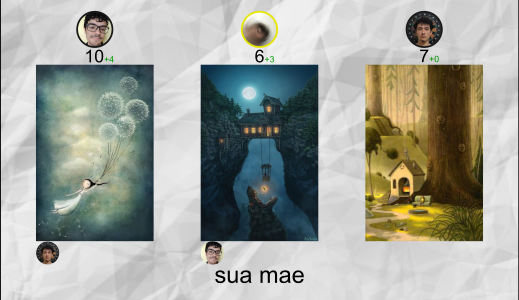

In [116]:
thomas_player = Player(User(id=910002159, is_bot=False, first_name='Thomas'))
solis_player = Player(User(id=26301886, is_bot=False, first_name='Solis'))
leo_player = Player(User(id=549081529, is_bot=False, first_name='Leo'))
card_thomas = Card(image_id=1, _id=1)
card_solis = Card(image_id=2, _id=2)
card_leo = Card(image_id=3, _id=3)
fake_results = DixitResults(players=[thomas_player, solis_player, leo_player],
                            storyteller=solis_player,
                            votes={thomas_player: solis_player, leo_player: thomas_player},
                            table={thomas_player: card_thomas, solis_player: card_solis, leo_player: card_leo},
                            clue='sua mae',
                            score={thomas_player: 10, solis_player: 6, leo_player: 7},
                            delta_score={thomas_player: 4, solis_player: 3, leo_player: 0}
                           )

card_hor_border=0.2
score_height=0.15
voted_pic_diam=0.3
voter_pic_diam=0.2
card_aspect_ratio=1.5
results_border=0.1
clue_height=0.2

player_border_color = (0.1, 0.1, 0.1)
storyteller_border_color = (0.9, 0.9, 0)
score_color = (0.0, 0.0, 0.0)
clue_color = (0.0, 0.0, 0.0)
delta_score_color = (0.0, 0.6, 0.0)

total_width = (1 + 2*card_hor_border)*len(fake_results.players) + 2*results_border
total_height = voted_pic_diam + score_height + card_aspect_ratio + voter_pic_diam + clue_height + 2*results_border

card_width=236/2
@disp(width=card_width*total_width, 
      height=card_width*total_height,
      results=fake_results)
def draw_results(ctx, results):
    # Draw background
    draw_background(ctx, int(card_width*total_width), int(card_width*total_height))
    
    ctx.scale(1/total_width, 
              1/total_height)
    ctx.select_font_face("Arial",
                         FONT_SLANT_NORMAL,
                         FONT_WEIGHT_NORMAL)
    # Write clue
    ctx.translate(0, total_height - results_border)

    ctx.set_source_rgb(*clue_color)
    ctx.set_font_size(clue_height)
    clue_extents = ctx.text_extents(results.clue)
    ctx.translate(total_width/2 - clue_extents.width / 2 - clue_extents.x_bearing,
                  (clue_extents.height-clue_height)/2)

    ctx.show_text(results.clue)

    ctx.translate(-(total_width/2 - clue_extents.width / 2 - clue_extents.x_bearing), 
                  -(clue_extents.height-clue_height)/2)
    ctx.translate(0, -(total_height - results_border))
    
    ctx.translate(results_border, results_border)    
    for player in results.players:
        ctx.translate(card_hor_border, 0)
        
        # Draw star in storyteller
        if player == results.storyteller:
            border_color = storyteller_border_color
        else:
            border_color = player_border_color
        
        # Draw profile pic above card
        ctx.translate(1/2 - voted_pic_diam/2, 0)
        ctx.scale(voted_pic_diam, voted_pic_diam)
        
        draw_profile_pic(ctx, f'tmp/pic_{player.id}.png', border_color=border_color) # modify this later
        
        ctx.scale(1/voted_pic_diam, 1/voted_pic_diam)
        ctx.translate(-(1/2 - voted_pic_diam/2), 0)
        
        # Draw total and delta scores
        ctx.translate(0, voted_pic_diam + score_height)
        
        ctx.set_source_rgb(*score_color)
        score_text = str(results.score[player])
        ctx.set_font_size(score_height)
        score_extents = ctx.text_extents(score_text)
        ctx.translate(1/2 - score_extents.width / 2 - score_extents.x_bearing, 
                      (score_extents.height-score_height)/2)
        
        ctx.show_text(score_text)
        
        ctx.set_source_rgb(*delta_score_color)
        delta_score_text = f'+{results.delta_score[player]}'
        ctx.set_font_size(score_height/2)
        ctx.show_text(delta_score_text)
        
        ctx.translate(-(1/2 - score_extents.width / 2 - score_extents.x_bearing), 
                      -(score_extents.height-score_height)/2)
        
        
        ctx.translate(0, -(voted_pic_diam + score_height))
        
        # Draw card
        
        ctx.translate(0, score_height + voted_pic_diam)
        ctx.scale(1, card_aspect_ratio)
        
        draw_card(ctx, results.table[player])
        
        ctx.scale(1, 1/card_aspect_ratio)
        ctx.translate(0, - (score_height + voted_pic_diam))
        
        # Draw profile pics below card
        # TODO what to do when there are many players
        n_voters=0
        for voter, voted in results.votes.items():
            if voted == player:
                ctx.translate(n_voters*(voted_pic_diam),
                              voted_pic_diam + score_height + card_aspect_ratio)
                
                ctx.scale(voter_pic_diam, voter_pic_diam)
                draw_profile_pic(ctx, f'tmp/pic_{voter.id}.png')
                ctx.scale(1/voter_pic_diam, 1/voter_pic_diam)
                
                ctx.translate(-n_voters*(voter_pic_diam),
                              -(voted_pic_diam + score_height + card_aspect_ratio))
                n_voters += 1
        
        # Translate to next card
        ctx.translate(1 + card_hor_border, 0)
    ctx.translate(-results_border, -results_border)